Mục tiêu:
1. Hiện thực một mô hình neural network from scratch (chỉ sử dụng numpy). So sánh độ chính xác với mô hình sử dụng thư viện tensorflow.
2. Tích hợp mã hóa Homomorphic Encryption vào mạng neural này để encrypt dữ liệu đầu vào.

# Data Processing

In [22]:
import numpy as np
import pandas as pd
import random

# random.seed(0)
n_X = 15
n_H = 3
n_Y = 1

def split_train_test(x, y, ratio=0.3):
    idxs = list(range(len(x)))
    random.shuffle(idxs)
    split_idx = int(len(x)*ratio)
    test_idxs, train_idxs = idxs[:split_idx], idxs[split_idx:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

def prepare_heart_disease_data():
    data = pd.read_csv("./data/framingham.csv")
    # Drop target columns
    X = data.drop(['TenYearCHD'], axis=1, inplace=False)
    Y = data['TenYearCHD']
    X = X.apply(lambda x: x.fillna(x.mean()),axis=0)
    # Standardize data
    X = (X - X.mean()) / X.std()
    return split_train_test(np.array(X), np.array(Y))

x_train, y_train, x_test, y_test = prepare_heart_disease_data()
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (2967, 15)
Shape of y_train: (2967,)
Shape of x_test: (1271, 15)
Shape of y_test: (1271,)


# Implement neural network from scratch
Kiến trúc của model:
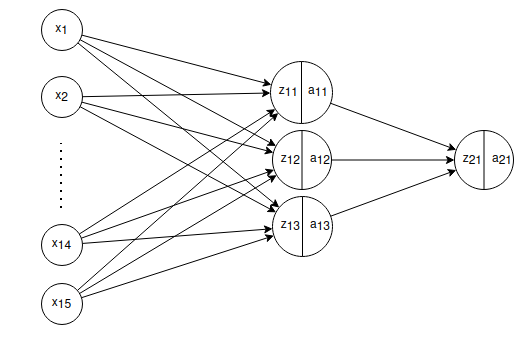

Forward Propagation:

$z_1 = W_1 . x + b_1$

$a_1 = \tanh(z_1)$

$z_2 = W_2 . a_1 + b_2$

$a_2 = \sigma{(z_2)}$

In [15]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class ScratchModel:
    def __init__(self):
        self.W1 = np.random.randn(n_H, n_X) * 0.01
        self.b1 = np.zeros((n_H, 1))
        self.W2 = np.random.randn(n_Y, n_H)
        self.b2 = np.zeros((n_Y, 1))
    
    def forward_propagation(self, X):
        Z1 = self.W1 @ X + self.b1
        A1 = np.tanh(Z1)
        Z2 = self.W2 @ A1 + self.b2
        A2 = sigmoid(Z2)
        history = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
        return A2, history
    
    def cost(self, A2, Y):
        m = Y.shape[1]
        L = np.multiply(Y, np.log(A2)) + np.multiply(1-Y, np.log(1-A2))
        J = (-1/m)*np.sum(L)
        return np.squeeze(J)
    
    def backward_propagation(self, history, X, Y):
        m = Y.shape[1]
        Z1, A1, Z2, A2 = history["Z1"], history["A1"], history["Z2"], history["A2"]
        dZ2 = A2 - Y
        dW2 = 1/m * (dZ2 @ A1.T)
        db2 = 1/m * np.sum(dZ2, axis=-1, keepdims=True)
        dZ1 = (self.W2.T @ dZ2) * (1 - A1**2)
        dW1 = 1/m * (dZ1 @ X.T)
        db1 = 1/m * np.sum(dZ1, axis=-1, keepdims=True)
        
        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return gradients
        
    def update(self, gradients, learning_rate=0.01):
        self.W1 -= learning_rate * gradients["dW1"]
        self.b1 -= learning_rate * gradients["db1"]
        self.W2 -= learning_rate * gradients["dW2"]
        self.b2 -= learning_rate * gradients["db2"]
        return
        
    def train(self, X, Y, learning_rate, iters):
        for i in range(iters):
            A2, history = self.forward_propagation(X)
            J = self.cost(A2, Y)
            grads = self.backward_propagation(history, X, Y)
            self.update(grads, learning_rate)
            if i % 1000 == 0:
                accuracy = self.test(X, Y)
                print(f"Cost after iterations {i}: {J} - accuracy: {accuracy}")
    
    def predict(self, x):
        a2, _ = self.forward_propagation(x)
        return a2
    
    def test(self, X, Y):
        m = Y.shape[1]
        A2, _ = self.forward_propagation(X)
        A2 = A2 > 0.5
        accuracy = np.sum((np.multiply(Y,A2) + np.multiply((1-Y),(1 - A2)))) / float(m)
        return accuracy

In [29]:
y_train = y_train.reshape((1, -1))
y_test = y_test.reshape((1, -1))
scratch_model = ScratchModel()
scratch_model.train(x_train.T, y_train, learning_rate=0.01, iters=10000)
accuracy = scratch_model.test(x_test.T, y_test)
print(f"The accuracy in test set is: {accuracy}")

Cost after iterations 0: 0.7003515895954125 - accuracy: 0.48870913380519043
Cost after iterations 1000: 0.3827986098862441 - accuracy: 0.8527131782945736
Cost after iterations 2000: 0.38242883485796547 - accuracy: 0.8513650151668352
Cost after iterations 3000: 0.3821960954127863 - accuracy: 0.8510279743849005
Cost after iterations 4000: 0.3819615005539144 - accuracy: 0.8513650151668352
Cost after iterations 5000: 0.3817240778170609 - accuracy: 0.8510279743849005
Cost after iterations 6000: 0.3814695439944373 - accuracy: 0.850690933602966
Cost after iterations 7000: 0.38119086950267433 - accuracy: 0.8503538928210314
Cost after iterations 8000: 0.3809026075225735 - accuracy: 0.8510279743849005
Cost after iterations 9000: 0.3806290711770866 - accuracy: 0.850690933602966
The accuracy in test set is: 0.8575924468922108


# So sánh với mô hình sử dụng tensorflow

In [30]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(15,)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

x_train, y_train, x_test, y_test = prepare_heart_disease_data()
history = model.fit(x_train, y_train, epochs=10)
loss_tf, accuracy_tf = model.evaluate(x_test, y_test)
print(f"The accuracy in test set is: {accuracy_tf}")

Epoch 1/10
93/93 [==============================] - 1s 3ms/step - loss: 0.6921 - accuracy: 0.5861
Epoch 2/10
93/93 [==============================] - 0s 3ms/step - loss: 0.5950 - accuracy: 0.6967
Epoch 3/10
93/93 [==============================] - 0s 3ms/step - loss: 0.5326 - accuracy: 0.7698
Epoch 4/10
93/93 [==============================] - 0s 3ms/step - loss: 0.4896 - accuracy: 0.8049
Epoch 5/10
93/93 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.8173
Epoch 6/10
93/93 [==============================] - 0s 3ms/step - loss: 0.4369 - accuracy: 0.8251
Epoch 7/10
93/93 [==============================] - 0s 3ms/step - loss: 0.4217 - accuracy: 0.8332
Epoch 8/10
93/93 [==============================] - 0s 4ms/step - loss: 0.4114 - accuracy: 0.8379
Epoch 9/10
93/93 [==============================] - 0s 4ms/step - loss: 0.4045 - accuracy: 0.8396
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3804 - accuracy: 0.8489
The accuracy in tes

**Nhận xét**: Accuracy giữa 2 model trên không có nhiều khác biệt!

# Implement Encrypted Neural Network

In [31]:
import tenseal as ts
class EncryptedModel:
    def __init__(self, plain_model: ScratchModel):
        self.W1 = plain_model.W1.T.tolist()
        self.b1 = plain_model.b1.squeeze().tolist()
        self.W2 = plain_model.W2.T.tolist()
        self.b2 = plain_model.b2.squeeze().tolist()

    # @staticmethod
    # def sigmoid_approx(enc_X: ts.CKKSVector) -> ts.CKKSVector:
    #     # sigmoid(x) ~= 0.5 + 0.197x - 0.004x^3
    #     return enc_X.polyval([0.5, 0.197, 0, -0.004])
    
    @staticmethod
    def tanh_approx(enc_X: ts.CKKSVector) -> ts.CKKSVector:
        # tanh(x) ~= 0.249476365628036*x - 0.00163574303018748*x^3
        return enc_X.polyval([0, 0.249476365628036, 0, -0.00163574303018748])
    
    def forward_propagation(self, enc_X: ts.CKKSVector) -> ts.CKKSVector:
        enc_Z1 = enc_X.matmul(self.W1) + self.b1
        enc_A1 = EncryptedModel.tanh_approx(enc_Z1)
        enc_Z2 = enc_A1.matmul(self.W2) + self.b2
        # enc_A2 = EncryptedModel.sigmoid_approx(enc_Z2)
        # We dont need to calculate sigmoid, it will be calculate after decryption to avoid error.
        return enc_Z2
    
    def predict(self, enc_X: ts.CKKSVector) -> ts.CKKSVector:
        z2 = self.forward_propagation(enc_X)
        return z2

In [32]:
enc_model = EncryptedModel(scratch_model)

Tạo cặp key để mã hóa input.

In [40]:
# parameters
poly_mod_degree = 8192
bits_scale = 26
# create TenSEALContext
ctx_eval = ts.context(
    ts.SCHEME_TYPE.CKKS, 
    poly_mod_degree, -1, 
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, 31])
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** bits_scale
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

Lưu private key và public key vào 2 file riêng biệt. Người dùng chỉ cần gửi public key cho server để tính toán và giữ lại private key để decrypt kết quả trả về.

In [37]:
# import base64
 
# def write_data(file_name: str, data: bytes):
#     data = base64.b64encode(data)
#     with open(file_name, 'wb') as f: 
#         f.write(data)
#     return
  
# def read_data(file_name: str) -> bytes:
#     with open(file_name, 'rb') as f:
#         data = f.read()
#     return base64.b64decode(data)

# # Store Private key
# secret_context = ctx_eval.serialize(save_secret_key = True)
# write_data('secret.txt', secret_context)
  
# # Drop private key
# ctx_eval.make_context_public()
# # Store public key
# public_context = ctx_eval.serialize()
# write_data('public.txt', public_context)

In [41]:
from time import time
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 8 seconds


In [42]:
t_start = time()
correct = 0
# It takes about 2 mins
for enc_x, y in zip(enc_x_test, y_test):
    enc_out = enc_model.predict(enc_x)
    # User receive encrypted output and then decrypt it
    out = enc_out.decrypt()[0]
    out = sigmoid(out) > 0.5
    if out == y:
        correct += 1
t_end = time()

print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
accuracy_enc = correct / len(x_test)
print(f"Model's Accuracy: {accuracy}")
print(f"Encrypted Model's Accuracy: {correct}/{len(x_test)} = {accuracy_enc}")

Evaluated test_set of 1271 entries in 122 seconds
Model's Accuracy: 0.8575924468922108
Encrypted Model's Accuracy: 1095/1271 = 0.8615263571990559
